**CONVOLUTIONAL AUTOENCODER**

In [1]:
import sys, os
from sys import argv
from csv import reader

import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models, layers,optimizers, losses, metrics
from keras.models import Model,load_model
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.optimizers import adam_v2

#reproducability
from numpy.random import seed
seed(185)
import tensorflow
tensorflow.random.set_seed(185)

Utility functions to read and proccess data

In [2]:
def read_params():
  print("Please provide the hyperparameters:")
  nodes = int(input("Number of nodes for the fully connected layer: "))
  epochs = int(input("Number of epochs: "))
  batch_size = int(input("Batch size: "))
  return nodes,epochs,batch_size

def read_data(dataset_path):
    dataset=open(dataset_path,"r")
    train_data = []
    with open(dataset_path, 'r') as read_obj:
        for row in dataset:
            serie=row.split()
            serie.pop(0) #throw way the time serie name
            serie=[float(x) for x in serie]
            train_data.append(np.array(serie))
    train_data=np.vstack(train_data)
    return train_data

def scale_data(train,test):
    scaler = MinMaxScaler()
    # scaler = StandardScaler()
    train=scaler.fit_transform(train)
    test =scaler.transform(test)
    return train,test

def preprocces_data(data):
    x=data.shape[0]
    y=data.shape[1]
    X = data.reshape((x,y, 1))
    return X,y

Defining model layers


In [ ]:
def encoder(input_data):
    conv1 = Conv1D(1825, 10, activation='relu', padding='same')(input_data)
    conv1 = BatchNormalization()(conv1)

    conv1 = MaxPooling1D(2)(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = Conv1D(912, 10, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
  
    conv2 = Conv1D(456, 10, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(1, 10, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization( name='bottleneck_layer')(conv2)
 
    return conv2

def decoder(encoded):
    conv = Conv1D(456, 10, activation='relu', padding='same')(encoded)
    conv = BatchNormalization()(conv)
    
    conv = Conv1D(912, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    conv = UpSampling1D(2)(conv)
    conv = Dropout(0.2)(conv)

    # conv = Conv1D(1825, 10, activation='relu', padding='same')(conv)
    # conv = BatchNormalization()(conv)

    conv = Conv1D(1825, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    decoded = Conv1D(1, 10, activation='sigmoid', padding='same')(conv)
    print(decoded)
    return decoded

First try

In [ ]:
dataset_path= 'nasdaq2007_17.csv'
data = read_data(dataset_path) #read file
train=data[:348,:]
test=data[348:,:]
train,test = scale_data(train,test) #scale file data
X,y=preprocces_data(train)#reshape train data 
X_test,y_test = preprocces_data(test)

input_data = Input(shape=(y, 1))
autoencoder = keras.Model(input_data, decoder(encoder(input_data)))

opt = adam_v2.Adam(learning_rate=0.00001)
# opt = RMSprop(learning_rate=0.000001)
autoencoder.compile(loss='mean_squared_error', optimizer = opt )
# Train the model
autoencoder_train = autoencoder.fit(X,X, batch_size=10,epochs=4,verbose=1,validation_data=(X_test,X_test),validation_batch_size=10)


KerasTensor(type_spec=TensorSpec(shape=(None, 3650, 1), dtype=tf.float32, name=None), name='conv1d_7/Sigmoid:0', description="created by layer 'conv1d_7'")
Epoch 1/4
35/35 [==============================] - 4194s 119s/step - loss: 0.1824 - val_loss: 0.2676
Epoch 2/4
35/35 [==============================] - 4209s 120s/step - loss: 0.1188 - val_loss: 0.2486
Epoch 3/4
35/35 [==============================] - 4154s 119s/step - loss: 0.1004 - val_loss: 0.2227
Epoch 4/4
35/35 [==============================] - 4154s 119s/step - loss: 0.0813 - val_loss: 0.1815


Plotting train and validation loss

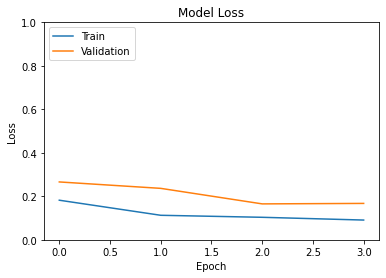

In [ ]:
#Plot the loss
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Experiments with different layers and parameters

Experimenting model 1 (layers)

KerasTensor(type_spec=TensorSpec(shape=(None, 3650, 1), dtype=tf.float32, name=None), name='conv1d_39/Sigmoid:0', description="created by layer 'conv1d_39'")
Epoch 1/4
35/35 [==============================] - 169s 4s/step - loss: 0.1263 - val_loss: 0.1833
Epoch 2/4
35/35 [==============================] - 153s 4s/step - loss: 0.0847 - val_loss: 0.1224
Epoch 3/4
35/35 [==============================] - 153s 4s/step - loss: 0.0567 - val_loss: 0.1288
Epoch 4/4
35/35 [==============================] - 153s 4s/step - loss: 0.0460 - val_loss: 0.1534


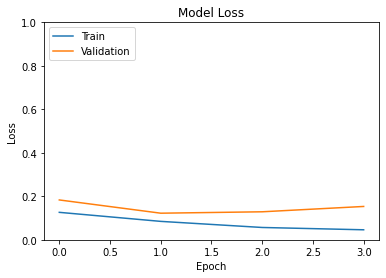

In [ ]:
def encoder(input_data):
    conv1 = Conv1D(1825, 10, activation='relu', padding='same')(input_data)
    conv1 = BatchNormalization()(conv1)

    conv1 = MaxPooling1D(2)(conv1)

    conv1 = Conv1D(912, 10, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
  
    conv2 = Conv1D(456, 10, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(1, 10, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization( name='bottleneck_layer')(conv2)
  
    return conv2

def decoder(encoded):
    conv = Conv1D(456, 10, activation='relu', padding='same')(encoded)
    conv = BatchNormalization()(conv)
    
    conv = Conv1D(912, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    conv = UpSampling1D(2)(conv)

    conv = Conv1D(1825, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    decoded = Conv1D(1, 10, activation='sigmoid', padding='same')(conv)
    print(decoded)
    return decoded

dataset_path= 'nasdaq2007_17.csv'
data = read_data(dataset_path) #read file
train=data[:348,:]
test=data[348:,:]
train,test = scale_data(train,test) #scale file data
X,y=preprocces_data(train)#reshape train data 
X_test,y_test = preprocces_data(test)

input_data = Input(shape=(y, 1))
autoencoder = keras.Model(input_data, decoder(encoder(input_data)))

opt = adam_v2.Adam(learning_rate=0.00001)
# opt = RMSprop(learning_rate=0.000001)
autoencoder.compile(loss='mean_squared_error', optimizer = opt )
# Train the model
autoencoder_train = autoencoder.fit(X,X, batch_size=10,epochs=4,verbose=1,validation_data=(X_test,X_test),validation_batch_size=10)

#Plot the loss
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Experimenting model 2 (layers)

KerasTensor(type_spec=TensorSpec(shape=(None, 3650, 1), dtype=tf.float32, name=None), name='conv1d_45/Sigmoid:0', description="created by layer 'conv1d_45'")
Epoch 1/4
35/35 [==============================] - 104s 2s/step - loss: 0.1345 - val_loss: 0.2188
Epoch 2/4
35/35 [==============================] - 76s 2s/step - loss: 0.0679 - val_loss: 0.1677
Epoch 3/4
35/35 [==============================] - 76s 2s/step - loss: 0.0560 - val_loss: 0.1194
Epoch 4/4
35/35 [==============================] - 76s 2s/step - loss: 0.0541 - val_loss: 0.0765


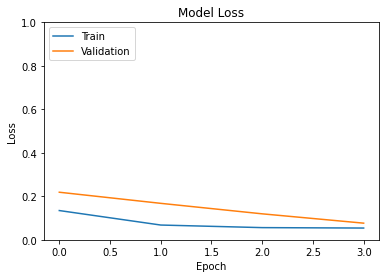

In [ ]:
def encoder(input_data):
    conv1 = Conv1D(1825, 10, activation='relu', padding='same')(input_data)
    conv1 = BatchNormalization()(conv1)

    conv1 = MaxPooling1D(2)(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv2 = Conv1D(456, 10, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(1, 10, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization( name='bottleneck_layer')(conv2)
    # conv2 = MaxPooling1D(2)(conv2)
    # conv2 = Dropout(0.2)(conv2)
    return conv2

def decoder(encoded):
    conv = Conv1D(456, 10, activation='relu', padding='same')(encoded)
    conv = BatchNormalization()(conv)
    
    conv = UpSampling1D(2)(conv)
    conv = Dropout(0.2)(conv)

    conv = Conv1D(1825, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    decoded = Conv1D(1, 10, activation='sigmoid', padding='same')(conv)
    print(decoded)
    return decoded

dataset_path= 'nasdaq2007_17.csv'
data = read_data(dataset_path) #read file
train=data[:348,:]
test=data[348:,:]
train,test = scale_data(train,test) #scale file data
X,y=preprocces_data(train)#reshape train data 
X_test,y_test = preprocces_data(test)

input_data = Input(shape=(y, 1))
autoencoder = keras.Model(input_data, decoder(encoder(input_data)))

opt = adam_v2.Adam(learning_rate=0.00001)
# opt = RMSprop(learning_rate=0.000001)
autoencoder.compile(loss='mean_squared_error', optimizer = opt )
# Train the model
autoencoder_train = autoencoder.fit(X,X, batch_size=10,epochs=4,verbose=1,validation_data=(X_test,X_test),validation_batch_size=10)

#Plot the loss
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def encoder(input_data):
    conv1 = Conv1D(3650, 10, activation='relu', padding='same')(input_data)
    conv1 = BatchNormalization()(conv1)

    conv1 = Conv1D(1825, 10, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)

    conv1 = MaxPooling1D(5)(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = Conv1D(912, 10, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
  
    conv2 = Conv1D(456, 10, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(1, 10, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization( name='bottleneck_layer')(conv2)

    return conv2

def decoder(encoded):
    conv = Conv1D(456, 10, activation='relu', padding='same')(encoded)
    conv = BatchNormalization()(conv)
    
    conv = Conv1D(912, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    conv = UpSampling1D(5)(conv)
    conv = Dropout(0.2)(conv)

    conv = Conv1D(1825, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)

    conv = Conv1D(3650, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    decoded = Conv1D(1, 10, activation='sigmoid', padding='same')(conv)
    print(decoded)
    return decoded

dataset_path= 'nasdaq2007_17.csv'
data = read_data(dataset_path) #read file
train=data[:300,:]
test=data[300:,:]
train,test = scale_data(train,test) #scale file data
X,y=preprocces_data(train)#reshape train data 
X_test,y_test = preprocces_data(test)

input_data = Input(shape=(y, 1))
autoencoder = keras.Model(input_data, decoder(encoder(input_data)))

opt = adam_v2.Adam(learning_rate=0.00001)
# opt = RMSprop(learning_rate=0.000001)
autoencoder.compile(loss='mean_squared_error', optimizer = opt )
# Train the model
autoencoder_train = autoencoder.fit(X,X, batch_size=10,epochs=4,verbose=1,validation_data=(X_test,X_test),validation_batch_size=10)

#Plot the loss
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

KerasTensor(type_spec=TensorSpec(shape=(None, 3650, 1), dtype=tf.float32, name=None), name='conv1d_17/Sigmoid:0', description="created by layer 'conv1d_17'")
Epoch 1/4
 2/30 [=>............................] - ETA: 4:44:01 - loss: 0.3554

In [ ]:
autoencoder.save('modelbig2.h5')
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3650, 1)]         0         
                                                                 
 conv1d_44 (Conv1D)          (None, 3650, 3650)        40150     
                                                                 
 batch_normalization_34 (Bat  (None, 3650, 3650)       14600     
 chNormalization)                                                
                                                                 
 conv1d_45 (Conv1D)          (None, 3650, 1825)        66614325  
                                                                 
 batch_normalization_35 (Bat  (None, 3650, 1825)       7300      
 chNormalization)                                                
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1825, 1825)       0   

Experimenting model 3 (latent dimensions)

KerasTensor(type_spec=TensorSpec(shape=(None, 3650, 1), dtype=tf.float32, name=None), name='conv1d_7/Sigmoid:0', description="created by layer 'conv1d_7'")
Epoch 1/4
35/35 [==============================] - 156s 4s/step - loss: 0.2427 - val_loss: 0.3286
Epoch 2/4
35/35 [==============================] - 120s 3s/step - loss: 0.1309 - val_loss: 0.2033
Epoch 3/4
35/35 [==============================] - 120s 3s/step - loss: 0.0988 - val_loss: 0.1736
Epoch 4/4
35/35 [==============================] - 120s 3s/step - loss: 0.1007 - val_loss: 0.2319


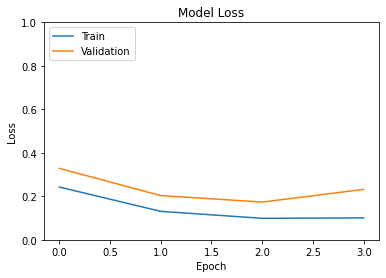

In [ ]:
def encoder(input_data):
    conv1 = Conv1D(1825, 10, activation='relu', padding='same')(input_data)
    conv1 = BatchNormalization()(conv1)

    conv1 = MaxPooling1D(5)(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = Conv1D(912, 10, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
  
    conv2 = Conv1D(456, 10, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(1, 10, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization( name='bottleneck_layer')(conv2)

    return conv2

def decoder(encoded):
    conv = Conv1D(456, 10, activation='relu', padding='same')(encoded)
    conv = BatchNormalization()(conv)
    
    conv = Conv1D(912, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    conv = UpSampling1D(5)(conv)
    conv = Dropout(0.2)(conv)

    conv = Conv1D(1825, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    decoded = Conv1D(1, 10, activation='sigmoid', padding='same')(conv)
    print(decoded)
    return decoded

dataset_path= 'nasdaq2007_17.csv'

data = read_data(dataset_path) #read file
train=data[:348,:]
test=data[348:,:]
train,test = scale_data(train,test) #scale file data
X,y=preprocces_data(train)#reshape train data 
X_test,y_test = preprocces_data(test)

input_data = Input(shape=(y, 1))
autoencoder = keras.Model(input_data, decoder(encoder(input_data)))

opt = adam_v2.Adam(learning_rate=0.00001)
# opt = RMSprop(learning_rate=0.000001)
autoencoder.compile(loss='mean_squared_error', optimizer = opt )
# Train the model
autoencoder_train = autoencoder.fit(X,X, batch_size=10,epochs=4,verbose=1,validation_data=(X_test,X_test),validation_batch_size=10)

#Plot the loss
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

KerasTensor(type_spec=TensorSpec(shape=(None, 3650, 1), dtype=tf.float32, name=None), name='conv1d_13/Sigmoid:0', description="created by layer 'conv1d_13'")
Epoch 1/4
35/35 [==============================] - 1582s 45s/step - loss: 0.1288 - val_loss: 0.2184
Epoch 2/4
35/35 [==============================] - 1573s 45s/step - loss: 0.0692 - val_loss: 0.1612
Epoch 3/4
35/35 [==============================] - 1571s 45s/step - loss: 0.0551 - val_loss: 0.1161
Epoch 4/4
35/35 [==============================] - 1572s 45s/step - loss: 0.0509 - val_loss: 0.0783


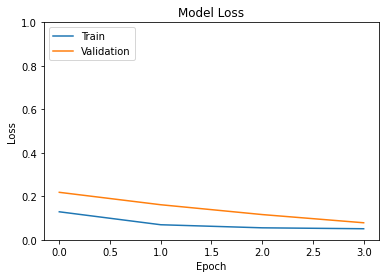

In [ ]:
def encoder(input_data):
    conv1 = Conv1D(1825, 10, activation='relu', padding='same')(input_data)
    conv1 = BatchNormalization()(conv1)

    conv1 = MaxPooling1D(5)(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv2 = Conv1D(456, 10, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(1, 10, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization( name='bottleneck_layer')(conv2)

    return conv2

def decoder(encoded):
    conv = Conv1D(456, 10, activation='relu', padding='same')(encoded)
    conv = BatchNormalization()(conv)
  
    conv = UpSampling1D(5)(conv)
    conv = Dropout(0.2)(conv)

    conv = Conv1D(1825, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    decoded = Conv1D(1, 10, activation='sigmoid', padding='same')(conv)
    print(decoded)
    return decoded

dataset_path= 'nasdaq2007_17.csv'

data = read_data(dataset_path) #read file
train=data[:348,:]
test=data[348:,:]
train,test = scale_data(train,test) #scale file data
X,y=preprocces_data(train)#reshape train data 
X_test,y_test = preprocces_data(test)

input_data = Input(shape=(y, 1))
autoencoder = keras.Model(input_data, decoder(encoder(input_data)))

opt = adam_v2.Adam(learning_rate=0.00001)
# opt = RMSprop(learning_rate=0.000001)
autoencoder.compile(loss='mean_squared_error', optimizer = opt )
# Train the model
autoencoder_train = autoencoder.fit(X,X, batch_size=10,epochs=4,verbose=1,validation_data=(X_test,X_test),validation_batch_size=10)

#Plot the loss
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Experimenting mdel 4 (batch size and epochs)

KerasTensor(type_spec=TensorSpec(shape=(None, 3650, 1), dtype=tf.float32, name=None), name='conv1d_91/Sigmoid:0', description="created by layer 'conv1d_91'")
Epoch 1/5
11/11 [==============================] - 149s 10s/step - loss: 0.1456 - val_loss: 0.2279
Epoch 2/5
11/11 [==============================] - 77s 7s/step - loss: 0.0640 - val_loss: 0.1996
Epoch 3/5
11/11 [==============================] - 77s 7s/step - loss: 0.0516 - val_loss: 0.1753
Epoch 4/5
11/11 [==============================] - 77s 7s/step - loss: 0.0533 - val_loss: 0.1535
Epoch 5/5
11/11 [==============================] - 77s 7s/step - loss: 0.0385 - val_loss: 0.1386


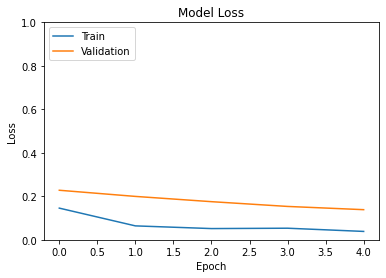

In [ ]:
def encoder(input_data):
    conv1 = Conv1D(1825, 10, activation='relu', padding='same')(input_data)
    conv1 = BatchNormalization()(conv1)

    conv1 = MaxPooling1D(5)(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = Conv1D(912, 10, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
  
    conv2 = Conv1D(456, 10, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(1, 10, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization( name='bottleneck_layer')(conv2)

    return conv2

def decoder(encoded):
    conv = Conv1D(456, 10, activation='relu', padding='same')(encoded)
    conv = BatchNormalization()(conv)
    
    conv = Conv1D(912, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    conv = UpSampling1D(5)(conv)
    conv = Dropout(0.2)(conv)

    conv = Conv1D(1825, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    decoded = Conv1D(1, 10, activation='sigmoid', padding='same')(conv)
    print(decoded)
    return decoded

dataset_path= 'nasdaq2007_17.csv'

data = read_data(dataset_path) #read file
train=data[:348,:]
test=data[348:,:]
train,test = scale_data(train,test) #scale file data
X,y=preprocces_data(train)#reshape train data 
X_test,y_test = preprocces_data(test)

input_data = Input(shape=(y, 1))
autoencoder = keras.Model(input_data, decoder(encoder(input_data)))

opt = adam_v2.Adam(learning_rate=0.00001)
# opt = RMSprop(learning_rate=0.000001)
autoencoder.compile(loss='mean_squared_error', optimizer = opt )
# Train the model
autoencoder_train = autoencoder.fit(X,X, batch_size=32,epochs=5,verbose=1,validation_data=(X_test,X_test),validation_batch_size=32)

#Plot the loss
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Experimenting model 5 (filter size)

KerasTensor(type_spec=TensorSpec(shape=(None, 3650, 1), dtype=tf.float32, name=None), name='conv1d_99/Sigmoid:0', description="created by layer 'conv1d_99'")
Epoch 1/4
35/35 [==============================] - 59s 1s/step - loss: 0.1313 - val_loss: 0.1613
Epoch 2/4
35/35 [==============================] - 38s 1s/step - loss: 0.0668 - val_loss: 0.0881
Epoch 3/4
35/35 [==============================] - 39s 1s/step - loss: 0.0655 - val_loss: 0.0510
Epoch 4/4
35/35 [==============================] - 38s 1s/step - loss: 0.0582 - val_loss: 0.0317


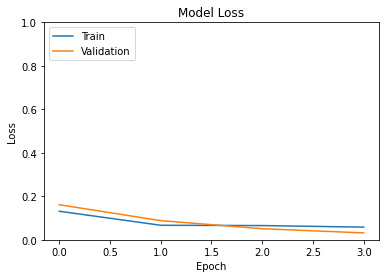

In [ ]:
def encoder(input_data):
    conv1 = Conv1D(1216, 10, activation='relu', padding='same')(input_data)
    conv1 = BatchNormalization()(conv1)

    conv1 = MaxPooling1D(5)(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = Conv1D(405, 10, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
  
    conv2 = Conv1D(135, 10, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(1, 10, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization( name='bottleneck_layer')(conv2)
    return conv2

def decoder(encoded):
    conv = Conv1D(135, 10, activation='relu', padding='same')(encoded)
    conv = BatchNormalization()(conv)
    
    conv = Conv1D(405, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    conv = UpSampling1D(5)(conv)
    conv = Dropout(0.2)(conv)

    conv = Conv1D(1216, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    decoded = Conv1D(1, 10, activation='sigmoid', padding='same')(conv)
    print(decoded)
    return decoded

dataset_path= 'nasdaq2007_17.csv'

data = read_data(dataset_path) #read file
train=data[:348,:]
test=data[348:,:]
train,test = scale_data(train,test) #scale file data
X,y=preprocces_data(train)#reshape train data 
X_test,y_test = preprocces_data(test)

input_data = Input(shape=(y, 1))
autoencoder = keras.Model(input_data, decoder(encoder(input_data)))

opt = adam_v2.Adam(learning_rate=0.00001)
# opt = RMSprop(learning_rate=0.000001)
autoencoder.compile(loss='mean_squared_error', optimizer = opt )
# Train the model
autoencoder_train = autoencoder.fit(X,X, batch_size=10,epochs=4,verbose=1,validation_data=(X_test,X_test),validation_batch_size=10)

#Plot the loss
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#BEST MODEL

KerasTensor(type_spec=TensorSpec(shape=(None, 3650, 1), dtype=tf.float32, name=None), name='conv1d_8/Sigmoid:0', description="created by layer 'conv1d_8'")
Epoch 1/4
30/30 [==============================] - 358s 10s/step - loss: 0.1980 - val_loss: 0.0280
Epoch 2/4
30/30 [==============================] - 284s 9s/step - loss: 0.1025 - val_loss: 0.0102
Epoch 3/4
30/30 [==============================] - 284s 9s/step - loss: 0.0776 - val_loss: 0.0114
Epoch 4/4
30/30 [==============================] - 284s 9s/step - loss: 0.0502 - val_loss: 0.0029


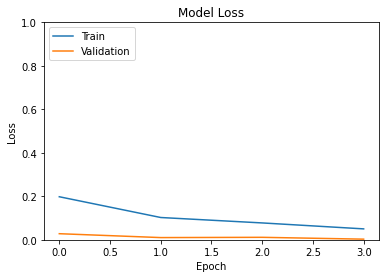

In [3]:
def encoder(input_data):
    conv1 = Conv1D(3650, 10, activation='relu', padding='same')(input_data)
    conv1 = BatchNormalization()(conv1)

    conv1 = Conv1D(1825, 10, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)

    conv1 = MaxPooling1D(5)(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = Conv1D(912, 10, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
  
    conv2 = Conv1D(456, 10, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(1, 10, activation='relu', padding='same',name='bottleneck_layer')(conv2)
    # conv2 = BatchNormalization( name='bottleneck_layer')(conv2)
    # conv2 = MaxPooling1D(2)(conv2)
    # conv2 = Dropout(0.2)(conv2)
    return conv2

def decoder(encoded):
    conv = Conv1D(456, 10, activation='relu', padding='same')(encoded)
    conv = BatchNormalization()(conv)
    
    conv = Conv1D(912, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    conv = UpSampling1D(5)(conv)
    conv = Dropout(0.2)(conv)

    conv = Conv1D(1825, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)

    conv = Conv1D(3650, 10, activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
  
    decoded = Conv1D(1, 10, activation='sigmoid', padding='same')(conv)
    print(decoded)
    return decoded

#parse comand line arguments
dataset_path= 'nasdaq2007_17.csv'
# for index, argument in enumerate(argv):
#     if argument == '-d': dataset_path = argv[index+1]

data = read_data(dataset_path) #read file
train=data[:300,:]
test=data[300:,:]
train,test = scale_data(train,test) #scale file data
X,y=preprocces_data(train)#reshape train data 
X_test,y_test = preprocces_data(test)

input_data = Input(shape=(y, 1))
autoencoder = keras.Model(input_data, decoder(encoder(input_data)))

opt = adam_v2.Adam(learning_rate=0.00001)
# opt = RMSprop(learning_rate=0.000001)
autoencoder.compile(loss='mean_squared_error', optimizer = opt )
# Train the model
autoencoder_train = autoencoder.fit(X,X, batch_size=10,epochs=4,verbose=1,validation_data=(X_test,X_test),validation_batch_size=10)

#Plot the loss
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [4]:
autoencoder.save('model.h5')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3650, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 3650, 3650)        40150     
                                                                 
 batch_normalization (BatchN  (None, 3650, 3650)       14600     
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 3650, 1825)        66614325  
                                                                 
 batch_normalization_1 (Batc  (None, 3650, 1825)       7300      
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 730, 1825)        0     